In [1]:
# Desenvolva um sistema de Processamento de Linguagem Natural que seja capaz de detectar 
# se um determinado SMS é normal ou spam. 
# Além de métodos simples, como floresta aleatória 
# e support vector machine (SVM), 
# use também uma long short-term memory (LSTM).

# Para essa tarefa, use a seguinte base de dados: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import requests
from io import BytesIO
from zipfile import ZipFile

import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

In [3]:
# Define the URL of the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

# Download the data and extract the contents of the ZIP archive
response = requests.get(url)
archive = ZipFile(BytesIO(response.content))

# Load the data
df = pd.read_csv(archive.open('SMSSpamCollection'), sep='\t', names=['label', 'message'])

In [4]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df['message']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: message, Length: 5572, dtype: object

In [6]:
# TIRAR PONTUAÇÃO E CARACTERES ESPECIAIS

def limpa_texto(data, col):
    data[col] = data[col].str.lower()
    data[col] = data[col].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "",x))

In [7]:
limpa_texto(df, 'message')

In [8]:
df['message']

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in 2 a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                   will  b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: message, Length: 5572, dtype: object

In [9]:
# REMOVER PALAVRAS COMUNS
# SEPARANDO PALAVRAS POR VÍRGULAS

def remove_palavras_comuns(data, col):
    palavras_comuns = stopwords.words('english')
    data[col] = data[col].apply(lambda x: ' '.join([word for word in x.split() 
                                                    if word not in palavras_comuns]))

In [10]:
remove_palavras_comuns(df, "message")

In [11]:
df['message']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u u 750 pound prize 2...
5568                            b going esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: message, Length: 5572, dtype: object

In [12]:
# REMOVER VARIAÇÃO DA MESMA PALAVRA

def tira_variacoes_de_palavras(data, col):
    tira_variacao = WordNetLemmatizer()
    data[col] = data[col].apply(lambda x: ' '.join([tira_variacao.lemmatize(word, 'v') 
                                                    for word in x.split()]))

In [13]:
tira_variacoes_de_palavras(df, 'message')

In [14]:
df['message']

0       go jurong point crazy available bugis n great ...
1                                   ok lar joke wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4                nah dont think go usf live around though
                              ...                        
5567    2nd time try 2 contact u u 750 pound prize 2 c...
5568                               b go esplanade fr home
5569                          pity mood soany suggestions
5570    guy bitch act like id interest buy something e...
5571                                       rofl true name
Name: message, Length: 5572, dtype: object

In [15]:
# ENGENHARIA DE RECURSOS (FEATURE ENGINEERING)

# QUANTIDADE DE PALAVRAS POR TWEET

df['palavras'] = df['message'].apply(len)

In [16]:
df

,label,message,palavras
0,ham,go jurong point crazy available bugis n great ...,82
1,ham,ok lar joke wif u oni,21
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,135
3,ham,u dun say early hor u c already say,35
4,ham,nah dont think go usf live around though,40
...,...,...,...
5567,spam,2nd time try 2 contact u u 750 pound prize 2 c...,108
5568,ham,b go esplanade fr home,22
5569,ham,pity mood soany suggestions,27
5570,ham,guy bitch act like id interest buy something e...,72


In [17]:
# ANÁLISE EXPLORATÓRIA DOS DADOS (AED)

# DISTRIBUIÇÃO DAS QUANTIDADES DE PALAVRAS POR 'LABEL'

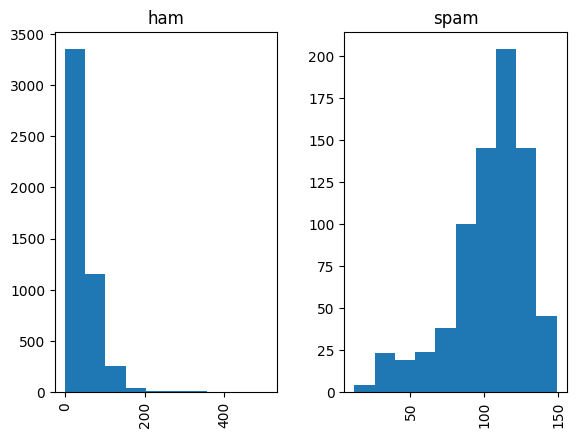

In [18]:
df.hist(column=['palavras'], by='label')
plt.show()

In [19]:
df

,label,message,palavras
0,ham,go jurong point crazy available bugis n great ...,82
1,ham,ok lar joke wif u oni,21
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,135
3,ham,u dun say early hor u c already say,35
4,ham,nah dont think go usf live around though,40
...,...,...,...
5567,spam,2nd time try 2 contact u u 750 pound prize 2 c...,108
5568,ham,b go esplanade fr home,22
5569,ham,pity mood soany suggestions,27
5570,ham,guy bitch act like id interest buy something e...,72


C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


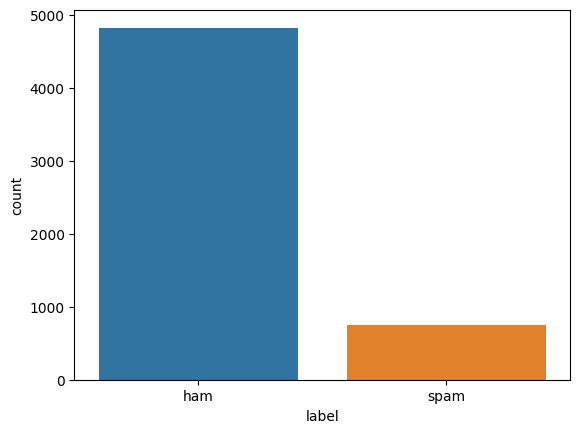

In [20]:
# QUANTIDADE DE CADA 'LABEL'

sns.countplot('label', data=df);
plt.show()

In [21]:
# PALAVRAS FREQUENTES

# AVERIGUAR PALAVRAS MAIS FREQUENTES CLASSIFICADAS COMO 'CARISTAS OU SEXISTAS'

In [22]:
df.loc[df['label']=='spam']['message']

2       free entry 2 wkly comp win fa cup final tkts 2...
5       freemsg hey darling 3 weeks word back id like ...
8       winner value network customer select receivea ...
9       mobile 11 months u r entitle update latest col...
11      six chance win cash 100 20000 pound txt csh11 ...
                              ...                        
5537    want explicit sex 30 secs ring 02073162414 cos...
5540    ask 3mobile 0870 chatlines inclu free mins ind...
5547    contract mobile 11 mnths latest motorola nokia...
5566    reminder o2 get 250 pound free call credit det...
5567    2nd time try 2 contact u u 750 pound prize 2 c...
Name: message, Length: 747, dtype: object

In [23]:
lista_de_listas = df.loc[df['label']=='spam', 'message'].values

In [24]:
lista_de_listas

array(['free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s',
       'freemsg hey darling 3 weeks word back id like fun still tb ok xxx std chgs send 150 rcv',
       'winner value network customer select receivea 900 prize reward claim call 09061701461 claim code kl341 valid 12 hours',
       'mobile 11 months u r entitle update latest colour mobiles camera free call mobile update co free 08002986030',
       'six chance win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6days 16 tsandcs apply reply hl 4 info',
       'urgent 1 week free membership 100000 prize jackpot txt word claim 81010 tc wwwdbuknet lccltd pobox 4403ldnw1a7rw18',
       'xxxmobilemovieclub use credit click wap link next txt message click xxxmobilemovieclubcomnqjkgighjjgcbl',
       'england v macedonia dont miss goalsteam news txt ur national team 87077 eg england 87077 trywales scotland 4txt120 poboxox36504w45wq 16',
     

In [25]:
[i for j in lista_de_listas for i in j] # SINTAXE PARA UMA LISTA DENTRO DE UMA LISTA

['f',
 'r',
 'e',
 'e',
 ' ',
 'e',
 'n',
 't',
 'r',
 'y',
 ' ',
 '2',
 ' ',
 'w',
 'k',
 'l',
 'y',
 ' ',
 'c',
 'o',
 'm',
 'p',
 ' ',
 'w',
 'i',
 'n',
 ' ',
 'f',
 'a',
 ' ',
 'c',
 'u',
 'p',
 ' ',
 'f',
 'i',
 'n',
 'a',
 'l',
 ' ',
 't',
 'k',
 't',
 's',
 ' ',
 '2',
 '1',
 's',
 't',
 ' ',
 'm',
 'a',
 'y',
 ' ',
 '2',
 '0',
 '0',
 '5',
 ' ',
 't',
 'e',
 'x',
 't',
 ' ',
 'f',
 'a',
 ' ',
 '8',
 '7',
 '1',
 '2',
 '1',
 ' ',
 'r',
 'e',
 'c',
 'e',
 'i',
 'v',
 'e',
 ' ',
 'e',
 'n',
 't',
 'r',
 'y',
 ' ',
 'q',
 'u',
 'e',
 's',
 't',
 'i',
 'o',
 'n',
 's',
 't',
 'd',
 ' ',
 't',
 'x',
 't',
 ' ',
 'r',
 'a',
 't',
 'e',
 't',
 'c',
 's',
 ' ',
 'a',
 'p',
 'p',
 'l',
 'y',
 ' ',
 '0',
 '8',
 '4',
 '5',
 '2',
 '8',
 '1',
 '0',
 '0',
 '7',
 '5',
 'o',
 'v',
 'e',
 'r',
 '1',
 '8',
 's',
 'f',
 'r',
 'e',
 'e',
 'm',
 's',
 'g',
 ' ',
 'h',
 'e',
 'y',
 ' ',
 'd',
 'a',
 'r',
 'l',
 'i',
 'n',
 'g',
 ' ',
 '3',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 'w',
 'o',
 'r',
 'd'

In [26]:
palavras = [word for sublist in lista_de_listas for word in sublist.split()]

In [27]:
len(palavras)

12515

In [28]:
import collections

In [29]:
def gera_freq_palavras(lista):
    return collections.Counter(lista)

In [30]:
gera_freq_palavras(palavras)

Counter({'free': 216,
         'entry': 26,
         '2': 173,
         'wkly': 14,
         'comp': 10,
         'win': 62,
         'fa': 4,
         'cup': 5,
         'final': 16,
         'tkts': 4,
         '21st': 2,
         'may': 7,
         '2005': 3,
         'text': 120,
         '87121': 4,
         'receive': 37,
         'questionstd': 2,
         'txt': 150,
         'ratetcs': 2,
         'apply': 29,
         '08452810075over18s': 2,
         'freemsg': 12,
         'hey': 5,
         'darling': 2,
         '3': 26,
         'weeks': 13,
         'word': 22,
         'back': 23,
         'id': 3,
         'like': 13,
         'fun': 9,
         'still': 7,
         'tb': 1,
         'ok': 5,
         'xxx': 11,
         'std': 9,
         'chgs': 1,
         'send': 80,
         '150': 39,
         'rcv': 2,
         'winner': 16,
         'value': 11,
         'network': 27,
         'customer': 49,
         'select': 26,
         'receivea': 2,
         '900': 7,
 

In [31]:
freq_palavras = gera_freq_palavras(palavras)

In [32]:
len(freq_palavras)

2726

In [33]:
data_freq = pd.DataFrame(freq_palavras.items(), columns=['palavra', 'freq'])
data_freq.sort_values('freq', ascending=False, inplace=True)

In [34]:
dict(data_freq[:10].values)

{'call': 366,
 'free': 216,
 '2': 173,
 'txt': 150,
 'u': 147,
 'ur': 144,
 'mobile': 123,
 'text': 120,
 '4': 119,
 'claim': 115}

In [35]:
# NÚVEM DE PALAVRAS

from wordcloud import WordCloud

In [36]:
nuvem = WordCloud(background_color='white')

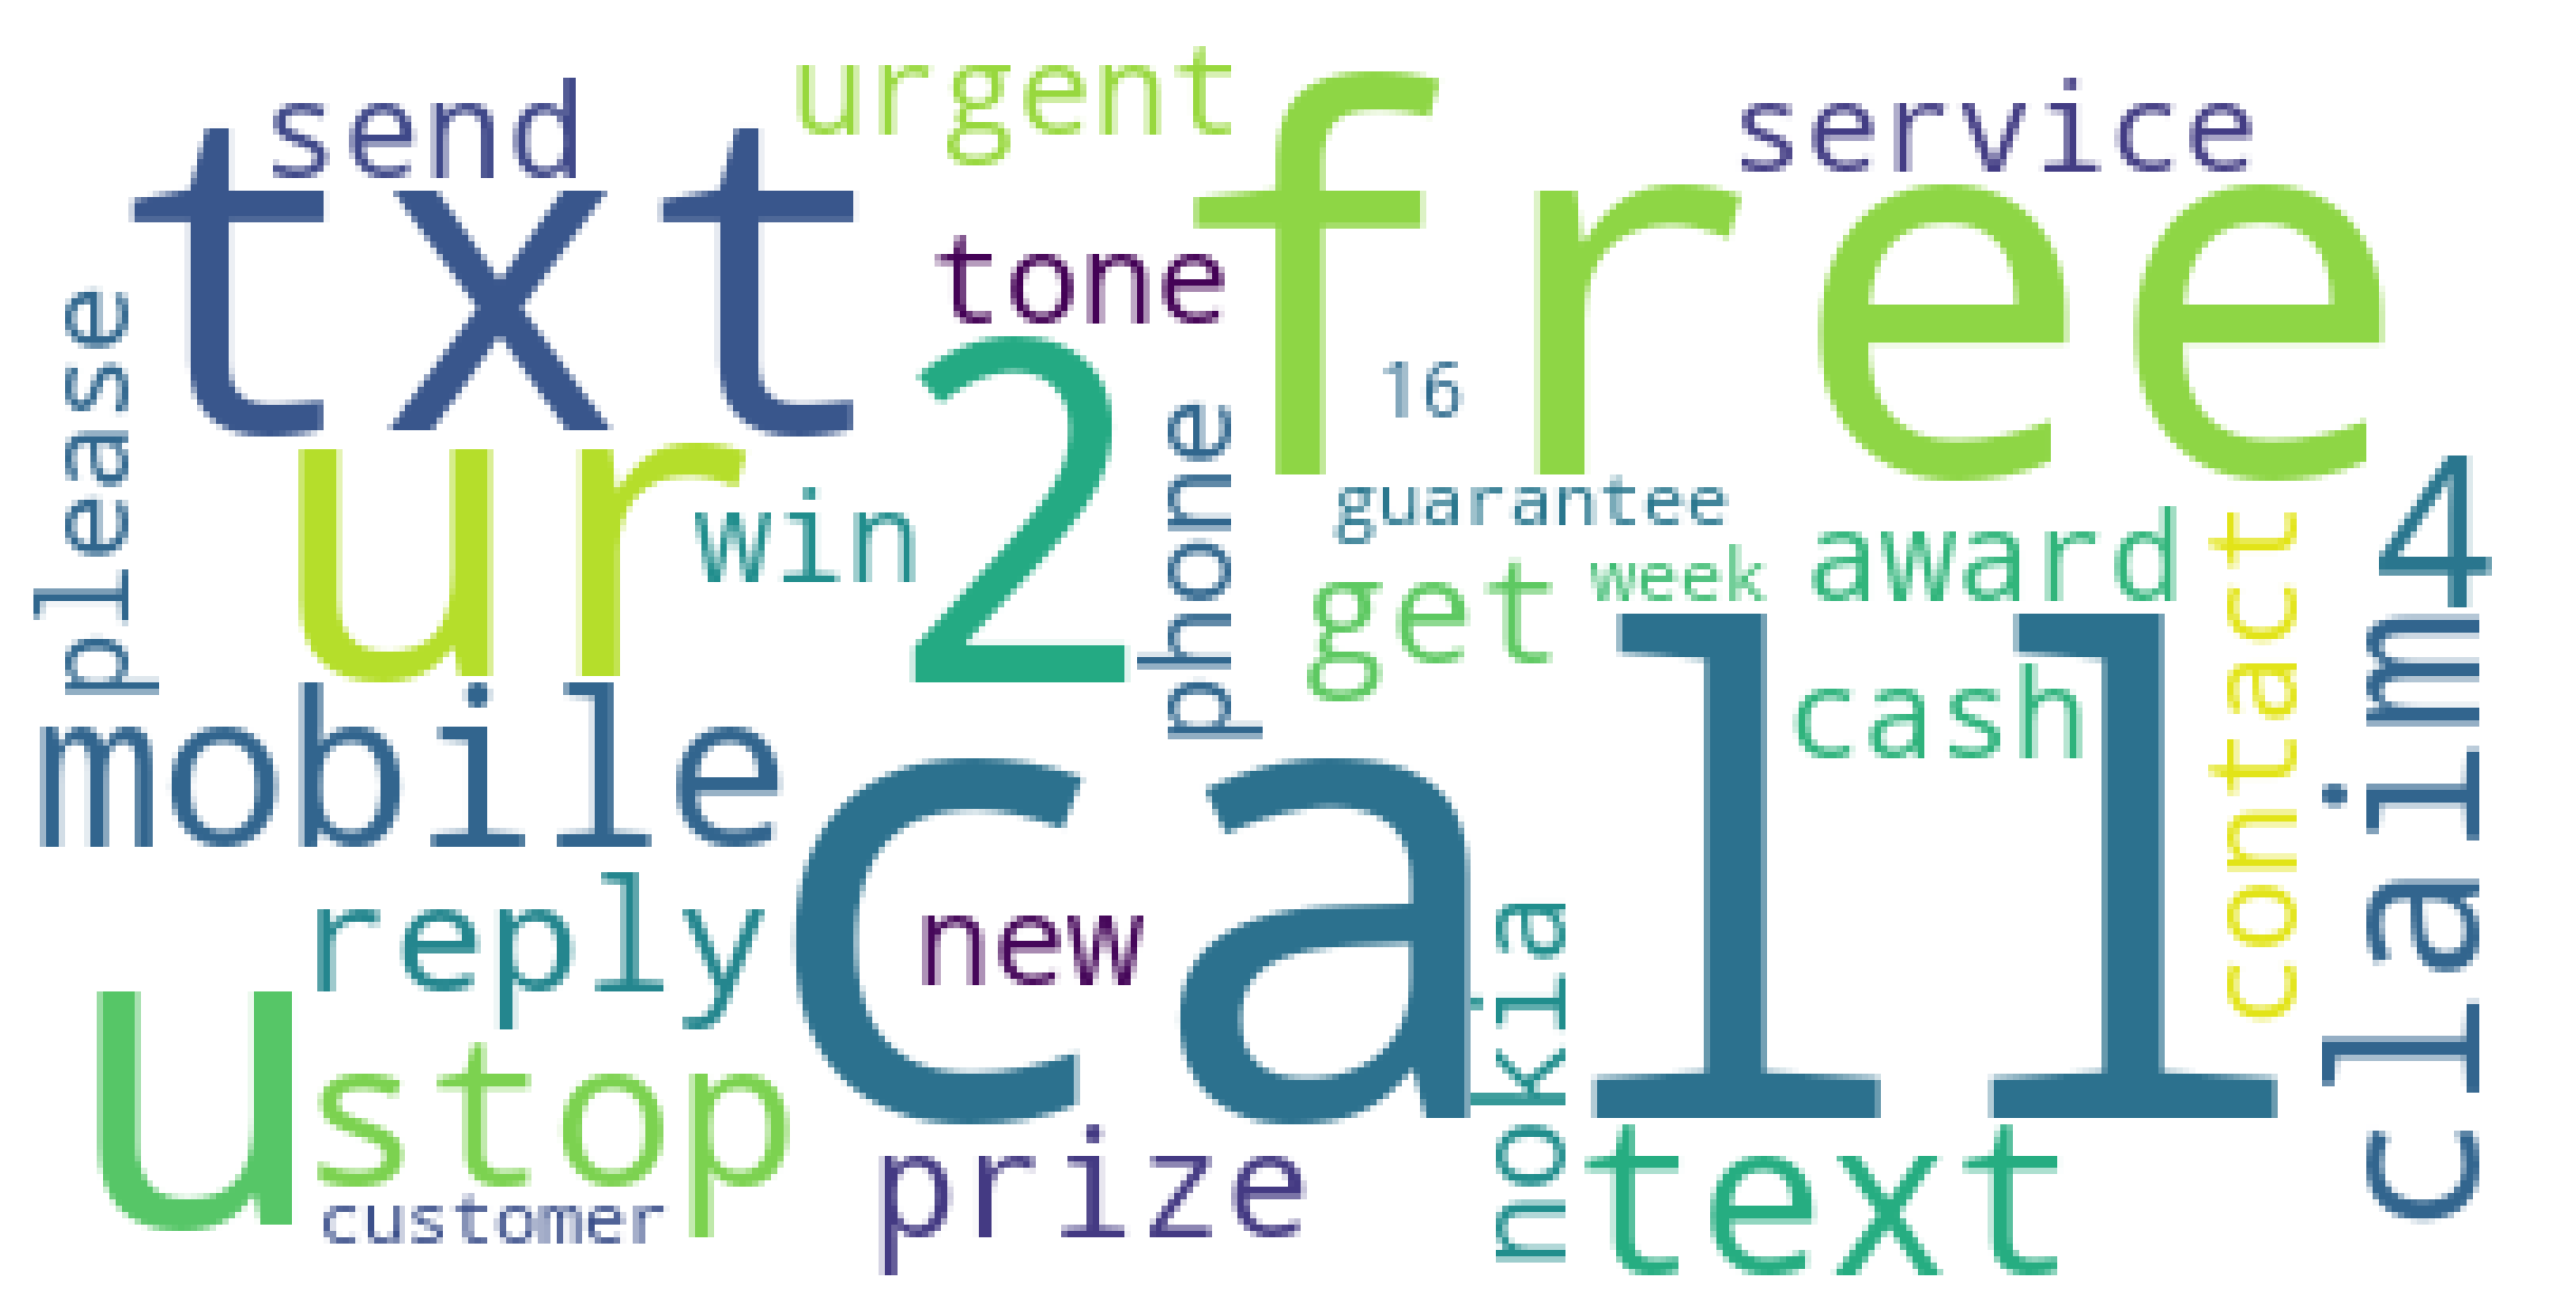

In [37]:
plt.figure(figsize=(12, 8), dpi=300)
nuvem.generate_from_frequencies(dict(data_freq[:30].values))
plt.imshow(nuvem)
plt.axis('off')
plt.show()

In [38]:
df['message'][7]

'per request melle melle oru minnaminunginte nurungu vettam set callertune callers press 9 copy friends callertune'

In [39]:
' '.join(df['message'][7])

'p e r   r e q u e s t   m e l l e   m e l l e   o r u   m i n n a m i n u n g i n t e   n u r u n g u   v e t t a m   s e t   c a l l e r t u n e   c a l l e r s   p r e s s   9   c o p y   f r i e n d s   c a l l e r t u n e'

In [40]:
# RETORNAR PARA FORMATO DE TEXTO

df['message'] = df['message'].apply(lambda x: ' '.join(x.split()))

In [41]:
# SOLUCIONAR PROBLEMA DE DESEQUILÍBRIO DE DADOS

df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [42]:
df_majority = df.loc[df['label'] == 'ham']

In [43]:
df_minority = df.loc[df['label'] == 'spam']

In [44]:
df_majority_downsampled = resample(df_majority, 
                                   replace=False, 
                                   n_samples=len(df_minority), 
                                   random_state=123)

In [45]:
df_majority_downsampled

,label,message,palavras
4307,ham,awww dat sweet think something nice time tonig...,91
4138,ham,get ltgt,8
4831,ham,word checkmate chess come persian phrase shah ...,86
4461,ham,wish great day moji tell offer always speechle...,124
5440,ham,thank generally date brothas,28
...,...,...,...
4707,ham,wow healthy old airport rd lor cant thk anythi...,74
3293,ham,dear good morning feel dear,27
1278,ham,dont put phone silent mode ok,29
4079,ham,gam go outstanding innings,26


In [46]:
df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [47]:
df_balanced

,label,message,palavras
4307,ham,awww dat sweet think something nice time tonig...,91
4138,ham,get ltgt,8
4831,ham,word checkmate chess come persian phrase shah ...,86
4461,ham,wish great day moji tell offer always speechle...,124
5440,ham,thank generally date brothas,28
...,...,...,...
5537,spam,want explicit sex 30 secs ring 02073162414 cos...,79
5540,spam,ask 3mobile 0870 chatlines inclu free mins ind...,134
5547,spam,contract mobile 11 mnths latest motorola nokia...,118
5566,spam,reminder o2 get 250 pound free call credit det...,104


In [48]:
# TREINAR MODELO

X = df_balanced['message']
y = df_balanced['label']

In [49]:
# Dividir em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
pipeline_svc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LinearSVC())
])

# Exemplo com Naive Bayes
pipeline_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

# Exemplo com Random Forest
pipeline_rf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])

# Exemplo com Gradient Boosting
pipeline_gb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', GradientBoostingClassifier())
])

In [51]:
# Treinamento e avaliação dos modelos
classifiers = {'Linear SVC': pipeline_svc, 
               'Naive Bayes': pipeline_nb, 
               'Random Forest': pipeline_rf, 
               'Gradient Boosting': pipeline_gb}

In [52]:
for clf_name, clf in classifiers.items():
    # Treinamento
    clf.fit(X_train, y_train)

    # Avaliação no conjunto de teste
    y_pred = clf.predict(X_test)
    print(f"\n{clf_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")


Linear SVC:
Accuracy: 0.9376391982182628
Confusion matrix:
[[209   8]
 [ 20 212]]
Classification report:
              precision    recall  f1-score   support

         ham       0.91      0.96      0.94       217
        spam       0.96      0.91      0.94       232

    accuracy                           0.94       449
   macro avg       0.94      0.94      0.94       449
weighted avg       0.94      0.94      0.94       449


Naive Bayes:
Accuracy: 0.9354120267260579
Confusion matrix:
[[201  16]
 [ 13 219]]
Classification report:
              precision    recall  f1-score   support

         ham       0.94      0.93      0.93       217
        spam       0.93      0.94      0.94       232

    accuracy                           0.94       449
   macro avg       0.94      0.94      0.94       449
weighted avg       0.94      0.94      0.94       449


Random Forest:
Accuracy: 0.9153674832962138
Confusion matrix:
[[215   2]
 [ 36 196]]
Classification report:
              precision 

In [53]:
# Predict new messages
def predict_message(text, pipeline):
    text_vect = pipeline.named_steps['vectorizer'].transform([text])
    prediction = pipeline.named_steps['classifier'].predict(text_vect)
    if prediction[0] == 'ham':
        return 'normal'
    else:
        return 'spam'

In [54]:
# Linear SVC
print("SVC:")
print(predict_message("Hey, what's up?", pipeline_svc))
print(predict_message("Free viagra call today!", pipeline_svc))
print(predict_message("freemsgfav xmas tonesreply", pipeline_svc))
print()

# Naive Bayes
print("Naive Bayes:")
print(predict_message("Hey, what's up?", pipeline_nb))
print(predict_message("Free viagra call today!", pipeline_nb))
print(predict_message("freemsgfav xmas tonesreply", pipeline_nb))
print()

# Random Forest
print("Random Forest:")
print(predict_message("Hey, what's up?", pipeline_rf))
print(predict_message("Free viagra call today!", pipeline_rf))
print(predict_message("freemsgfav xmas tonesreply", pipeline_rf))
print()

# Gradient Boosting
print("Gradient Boosting:")
print(predict_message("Hey, what's up?", pipeline_gb))
print(predict_message("Free viagra call today!", pipeline_gb))
print(predict_message("freemsgfav xmas tonesreply", pipeline_gb))

SVC:
normal
spam
spam

Naive Bayes:
normal
spam
spam

Random Forest:
normal
spam
normal

Gradient Boosting:
normal
normal
normal


In [55]:
# ========================================================

In [56]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [57]:
# Converting text to numerical sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [58]:
# Padding to have sequences of uniform length
max_sequence_length = max([len(x) for x in X_train_seq])

In [59]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [60]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [61]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_sequence_length))
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

In [62]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
# Train the LSTM model
model_lstm.fit(X_train_padded, y_train_encoded, validation_data=(X_test_padded, y_test_encoded), epochs=5, batch_size=32)

Epoch 1/5
33/33 [==============================] - 3s 32ms/step - loss: 0.5559 - accuracy: 0.7589 - val_loss: 0.4590 - val_accuracy: 0.8330
Epoch 2/5
33/33 [==============================] - 1s 25ms/step - loss: 0.2124 - accuracy: 0.9225 - val_loss: 0.1610 - val_accuracy: 0.9443
Epoch 3/5
33/33 [==============================] - 1s 26ms/step - loss: 0.0628 - accuracy: 0.9828 - val_loss: 0.1328 - val_accuracy: 0.9555
Epoch 4/5
33/33 [==============================] - 1s 25ms/step - loss: 0.0246 - accuracy: 0.9943 - val_loss: 0.1680 - val_accuracy: 0.9510
Epoch 5/5
33/33 [==============================] - 1s 25ms/step - loss: 0.0105 - accuracy: 0.9990 - val_loss: 0.1689 - val_accuracy: 0.9555


In [64]:
# Evaluate the LSTM model
y_pred_lstm = (model_lstm.predict(X_test_padded) > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test_encoded, y_pred_lstm)
print(f"LSTM Accuracy: {accuracy_lstm}")
print(f"LSTM Confusion matrix:\n{confusion_matrix(y_test_encoded, y_pred_lstm)}")
print(f"LSTM Classification report:\n{classification_report(y_test_encoded, y_pred_lstm)}")

15/15 [==============================] - 0s 3ms/step
LSTM Accuracy: 0.955456570155902
LSTM Confusion matrix:
[[216   1]
 [ 19 213]]
LSTM Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       217
           1       1.00      0.92      0.96       232

    accuracy                           0.96       449
   macro avg       0.96      0.96      0.96       449
weighted avg       0.96      0.96      0.96       449



In [65]:
# Predict new messages using the LSTM model
def predict_message_lstm(text, tokenizer, model):
    text_seq = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_seq, maxlen=max_sequence_length)
    prediction = (model.predict(text_padded) > 0.5).astype(int)
    if prediction[0][0] == 0:
        return 'normal'
    else:
        return 'spam'

In [66]:
# Test predictions with the LSTM model
print("LSTM Predictions:")
print(predict_message_lstm("Hey, what's up?", tokenizer, model_lstm))
print(predict_message_lstm("Free viagra call today!", tokenizer, model_lstm))
print(predict_message_lstm("freemsgfav xmas tonesreply", tokenizer, model_lstm))

LSTM Predictions:
1/1 [==============================] - 0s 17ms/step
normal
1/1 [==============================] - 0s 17ms/step
spam
1/1 [==============================] - 0s 16ms/step
normal
